<h1>Final Project: Seinfeld - Social Network Analysis</h1>

<h3> DATA 620 Web Analytics, CUNY Spring 2018 </h3>

Team: Andy Carson, Nathan Cooper, Walt Wells

Video: 

Proposal:

<h2>Project Requirements</h2>

Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as a Jupyter Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 


<h2>Project Solution: Social Network Analysis</h2>




In [129]:
import networkx as nx #note: this is version 2.1
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from networkx.algorithms import bipartite as bi
import math
import re

plt.figure(figsize = (17,8))
% matplotlib inline

<h2> Read In Data</h2>

Pull in pre-processed and cleaned data from GitHub.

In [130]:
#read in data
sf_cast = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Cast.csv")
sf_dialogue = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Dialogue.csv")
sf_dialgoue_sub = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_DialogueSUBSET.csv")
sf_metadata = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Metadata.csv")
sf_writers = pd.read_csv("https://raw.githubusercontent.com/wwells/CUNY_DATA_620_GROUP/master/Final_Project/Data/Seinfield_Writers.csv")

In [194]:
sf_cast.head(5)

,Actor,Character,SEID,season,episode
0,Jerry Seinfeld,Jerry Seinfeld,S01E00,S01,00
1,Jason Alexander,George Costanza,S01E00,S01,00
2,Michael Richards,Kessler,S01E00,S01,00
3,Lee Garlington,Claire,S01E00,S01,00
4,Pamela Brull,Laura,S01E00,S01,00


In [132]:
sf_dialogue.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [133]:
sf_dialgoue_sub.head(5)

,Character,Dialogue,DialogueIndex,SEID,SceneNum
0,JERRY,Do you know what this is all about? Do you kno...,1,S01E00,S01E00_1
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",1,S01E00,S01E00_2
2,GEORGE,Are you through?,2,S01E00,S01E00_2
3,JERRY,"You do of course try on, when you buy?",3,S01E00,S01E00_2
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",4,S01E00,S01E00_2


In [134]:
sf_metadata.head(5)

,AirDate,Director,Episode,SEID,Season,Title
0,"July 5, 1989",Art Wolff,1,S01E00,1,"Good News, Bad News"
1,"May 31, 1990",Tom Cherones,1,S01E01,1,The Stakeout
2,"June 7, 1990",Tom Cherones,2,S01E02,1,The Robbery
3,"June 14, 1990",Tom Cherones,3,S01E03,1,Male Unbonding
4,"June 21, 1990",Tom Cherones,4,S01E04,1,The Stock Tip


In [135]:
sf_writers.head(5)

,Writers,SEID
0,Larry David,S01E00
1,Jerry Seinfeld,S01E00
2,Larry David,S01E01
3,Jerry Seinfeld,S01E01
4,Matt Goldman,S01E02


<h2>Functions </h2>

In [168]:
def centrality_measures(g):
    degree = nx.degree(g)
    degree = dict(list(degree))
    sort_degree = sorted(degree.iteritems(), key=lambda(k,v): (-v,k))
    print "Degree:"
    print sort_degree[0:10]
    print
    
    closeness = nx.closeness_centrality(g)
    print "Closeness:"
    print sorted(closeness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    betweenness = nx.betweenness_centrality(g)
    print "Betweenness:"
    print sorted(betweenness.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    eigenvector = nx.eigenvector_centrality(g)
    print "Eigenvector:"
    print sorted(eigenvector.iteritems(), key=lambda(k,v): (-v,k))[0:10]
    print
    
    pagerank = nx.pagerank(g)
    print "Pagerank:"
    print sorted(pagerank.iteritems(), key=lambda(k,v): (-v,k))[0:10]

In [137]:
#####
## islands method
# taken from SNA chp 4 pg 64.  Modified appropriately.
########

def trim_edges(g, weight = 1):
    edges = []
    g2 = nx.Graph()
    for f, to, edata in g.edges(data=True):
        if edata['weight']> weight:
            x = float(edata['weight'])
            edges.append((f,to,x))
    g2.add_weighted_edges_from(edges)
    return g2


def island_method(g, iterations=5):
    weights = [edata['weight'] for f, to, edata in g.edges(data=True)]
    
    #size of step
    mn=int(min(weights))
    mx=int(max(weights))
    step = int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn, mx, step)]

In [219]:
def show_island_graphs(g_island,threshold,labels):
    g_weights = [math.log(float(edata['weight'])) for f, t, edata in g_island[threshold][1].edges(data=True)]
    nx.draw_spring(g_island[threshold][1], width=g_weights, edge_color=g_weights, with_labels=labels)

<h2> Graph: Character to Season </h2>

In [138]:
sf_cast.head(5)

,Actor,Character,SEID
0,Jerry Seinfeld,Jerry Seinfeld,S01E00
1,Jason Alexander,George Costanza,S01E00
2,Michael Richards,Kessler,S01E00
3,Lee Garlington,Claire,S01E00
4,Pamela Brull,Laura,S01E00


In [139]:
#reference: https://pandas.pydata.org/pandas-docs/stable/10min.html
sf_cast_episode = pd.DataFrame(sf_cast['SEID'].str.split("E").tolist(), columns = ['season','episode'])
sf_cast = sf_cast.join(sf_cast_episode)

In [180]:
sf_cast.head(5)

,Actor,Character,SEID,season,episode
0,Jerry Seinfeld,Jerry Seinfeld,S01E00,S01,00
1,Jason Alexander,George Costanza,S01E00,S01,00
2,Michael Richards,Kessler,S01E00,S01,00
3,Lee Garlington,Claire,S01E00,S01,00
4,Pamela Brull,Laura,S01E00,S01,00


In [181]:
sf_cast_group = sf_cast.groupby(['Actor','season'], as_index=False).count()
sf_cast_group = sf_cast_group[['Actor','season', 'episode']]
sf_cast_group.columns = ['Actor','season', 'Counts']

In [182]:
sf_cast_group.head(5)

,Actor,season,Counts
0,A.J. Langer,S08,1
1,Aaron Kanarek,S03,1
2,Adam Leslie,S03,1
3,Adam Wylie,S03,1
4,Adelaide Miller,S06,1


In [183]:
#make graph
characters_season = nx.Graph(name = "Actors and Seasson")

In [184]:
#get nodes-users and sites
node_values_cast = list(sf_cast_group.Actor.values) + list(sf_cast_group.season.values)

In [185]:
characters_season.add_nodes_from(node_values_cast)

In [186]:
#get edges
edges_tuples_cast = [tuple(x) for x in sf_cast_group.values]

In [187]:
characters_season.add_weighted_edges_from(edges_tuples_cast)

In [188]:
#weight the data for edge width and coloring.  Code borrowed and modified from SNA.
weights = [float(edata['weight']) for f, t, edata in characters_season.edges(data=True)]

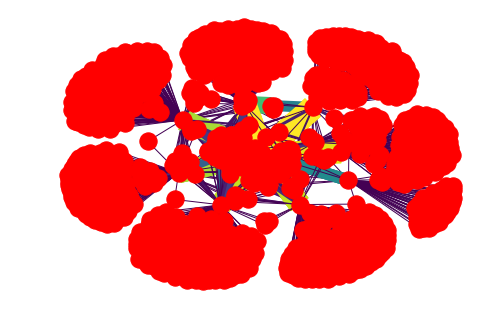

In [189]:
nx.draw_spring(characters_season, with_labels=False, width = weights, edge_color = weights)

<h3> Projected Graph: Character to Season </h3>

In [190]:
character_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.Actor.values), ratio=False)

In [191]:
character_graph.number_of_edges()

120325

In [192]:
character_graph.number_of_nodes()

1158

In [193]:
centrality_measures(character_graph) #takes awhile to run

Degree:
[('Jason Alexander', 1157), ('Jerry Seinfeld', 1157), ('Julia Louis-Dreyfus', 1157), ('Michael Richards', 1157), ('Wayne Knight', 1092), ('Liz Sheridan', 1055), ('Len Lesser', 1035), ('Barney Martin', 985), ('Estelle Harris', 985), ('Jerry Stiller', 985)]

Closeness:
[('Jason Alexander', 1.0), ('Jerry Seinfeld', 1.0), ('Julia Louis-Dreyfus', 1.0), ('Michael Richards', 1.0), ('Wayne Knight', 0.9468085106382979), ('Liz Sheridan', 0.9189833200953137), ('Len Lesser', 0.9046129788897577), ('Barney Martin', 0.8705793829947329), ('Estelle Harris', 0.8705793829947329), ('Jerry Stiller', 0.8705793829947329)]

Betweenness:
[('Jason Alexander', 0.056323838548247226), ('Jerry Seinfeld', 0.056323838548247226), ('Julia Louis-Dreyfus', 0.056323838548247226), ('Michael Richards', 0.056323838548247226), ('Wayne Knight', 0.04254707389386355), ('Liz Sheridan', 0.040616403262133595), ('Len Lesser', 0.035426396987549555), ('Barney Martin', 0.027383543036812213), ('Estelle Harris', 0.027383543036812

In [195]:
weights_character_graph = [float(edata['weight']) for f, t, edata in character_graph.edges(data=True)]

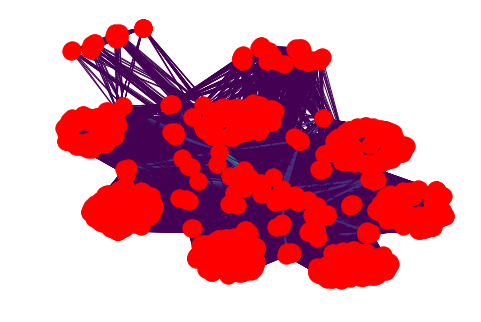

In [198]:
nx.draw_spring(character_graph, width=weights_character_graph, edge_color=weights_character_graph, with_labels=False)

<h3> Projected Graph: Season</h3>

In [199]:
################
## sites
##############
season_graph = bi.weighted_projected_graph(characters_season, list(sf_cast_group.season.values), ratio=False)

In [200]:
season_graph = list(nx.connected_component_subgraphs(season_graph))[0]

In [201]:
season_graph.number_of_edges()

36

In [202]:
season_graph.number_of_nodes()

9

In [203]:
centrality_measures(season_graph)

Degree:
[('S01', 8), ('S02', 8), ('S03', 8), ('S04', 8), ('S05', 8), ('S06', 8), ('S07', 8), ('S08', 8), ('S09', 8)]

Closeness:
[('S01', 1.0), ('S02', 1.0), ('S03', 1.0), ('S04', 1.0), ('S05', 1.0), ('S06', 1.0), ('S07', 1.0), ('S08', 1.0), ('S09', 1.0)]

Betweenness:
[('S01', 0.0), ('S02', 0.0), ('S03', 0.0), ('S04', 0.0), ('S05', 0.0), ('S06', 0.0), ('S07', 0.0), ('S08', 0.0), ('S09', 0.0)]

Eigenvector:
[('S01', 0.33333333333333337), ('S02', 0.33333333333333337), ('S03', 0.33333333333333337), ('S04', 0.33333333333333337), ('S05', 0.33333333333333337), ('S06', 0.33333333333333337), ('S07', 0.33333333333333337), ('S08', 0.33333333333333337), ('S09', 0.33333333333333337)]

Pagerank:
[('S08', 0.1434942043226922), ('S07', 0.1318409095299596), ('S06', 0.13082253911668065), ('S09', 0.13079574454678747), ('S05', 0.12284040304997577), ('S04', 0.1159864868159047), ('S03', 0.08670297886058641), ('S02', 0.07946020473082635), ('S01', 0.05805652902658701)]


In [205]:
weights_season_graph = [float(edata['weight']) for f, t, edata in season_graph.edges(data=True)]

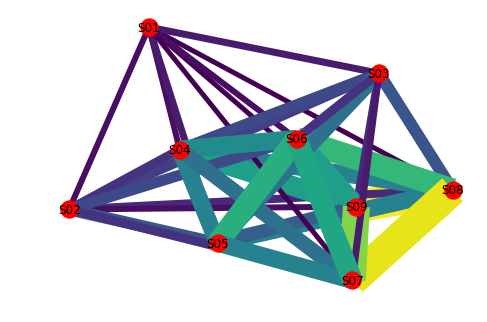

In [207]:
nx.draw_spring(season_graph, width=weights_season_graph, edge_color=weights_season_graph, with_labels=True)

<h3> Island Method</h3>

Let's pair down each of the projected graphs using the island method.

In [208]:
#users
character_island = island_method(character_graph)

In [209]:
print "Threshold, Nodes, Edges, Number of Connected Components"
for i in character_island:
    print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

Threshold, Nodes, Edges, Number of Connected Components
1 123 2007 1
2 34 342 1
3 23 169 1
4 15 75 1
5 11 49 1
6 7 19 1
7 5 10 1
8 4 6 1


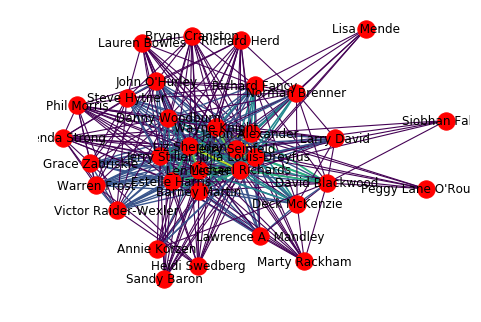

In [225]:
show_island_graphs(character_island,1,True)

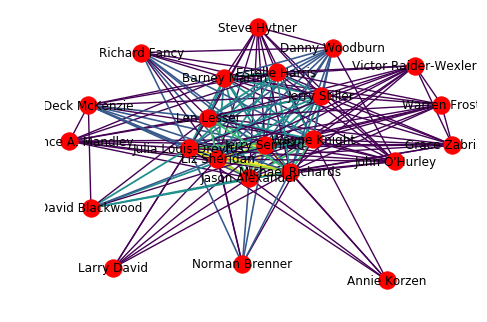

In [226]:
show_island_graphs(character_island,2,True)

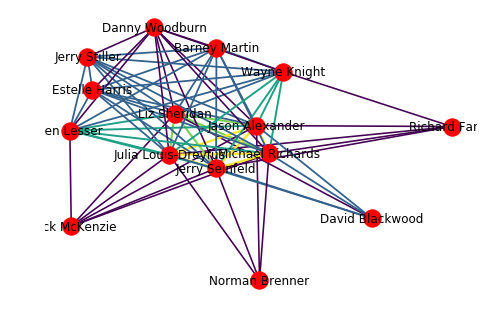

In [227]:
show_island_graphs(character_island,3,True)

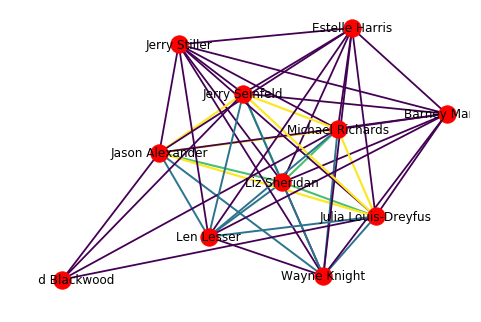

In [228]:
show_island_graphs(character_island,4,True)

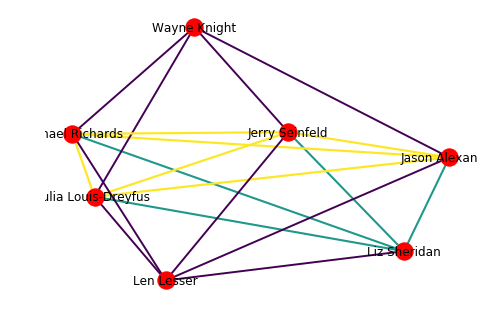

In [229]:
show_island_graphs(character_island,5,True)

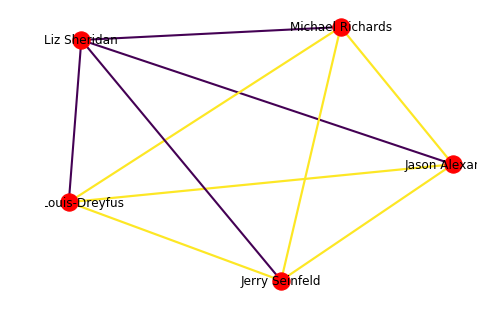

In [230]:
show_island_graphs(character_island,6,True)

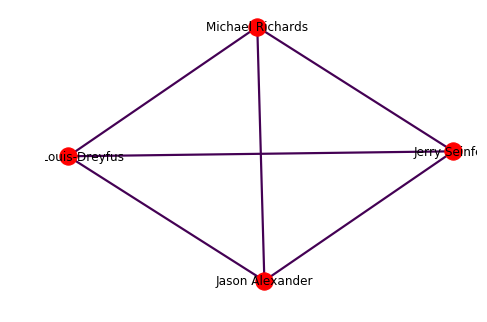

In [231]:
show_island_graphs(character_island,7,True)

In [232]:
## season
season_island = island_method(season_graph)

For the site graph, we see that we can reduce from 120, to 9, 6, 3, 2, 2 nodes by increasing the weight threshold.  The graph always has 1 connected component.

In [233]:
print "Threshold, Nodes, Edges, Number of Connected Components"
for i in season_island:
    print i[0], nx.number_of_nodes(i[1]), nx.number_of_edges(i[1]), nx.number_connected_components(i[1])

Threshold, Nodes, Edges, Number of Connected Components
5 9 33 1
10 8 20 1
15 6 13 1
20 5 6 1
25 3 3 1
30 3 2 1


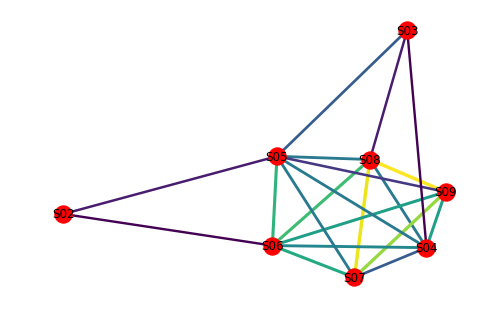

In [234]:
show_island_graphs(season_island,1,True)

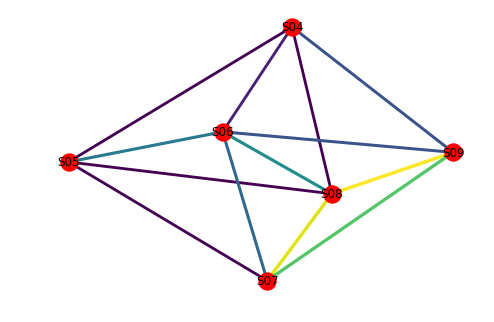

In [237]:
show_island_graphs(season_island,2,True)

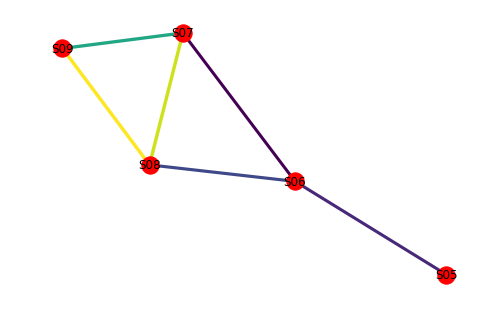

In [238]:
show_island_graphs(season_island,3,True)

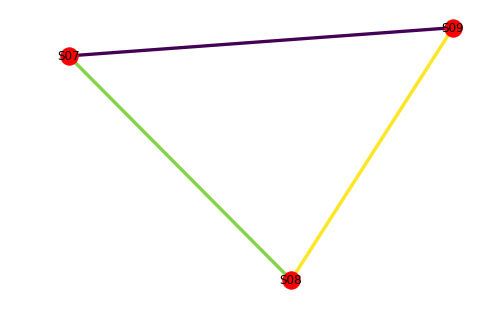

In [239]:
show_island_graphs(season_island,4,True)

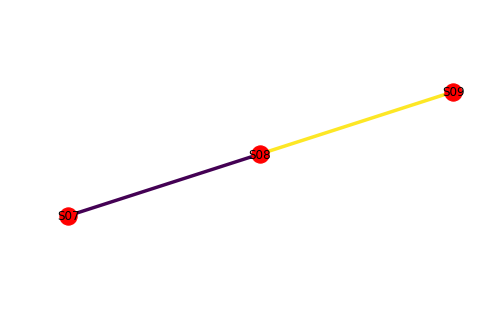

In [240]:
show_island_graphs(season_island,5,True)

<h2> Conclusion </h2>
